# Relax Inc

##### Problem Statement:
Defining an "adopted user" as a user who has logged into the product on  three separate days in at least one seven-day period, identify which factors predict future user adoption.


### 1. Sourcing and Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

### change column name to user_id for better understanding and to match the other data
users = users.rename(columns={'object_id':'user_id'})

users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### Usage Summary
I need to create the target from these data

In [4]:
engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'])
engagement.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
print('Min:',min(engagement.time_stamp))
print('Max:',max(engagement.time_stamp))

Min: 2012-05-31 08:20:06
Max: 2014-06-06 14:58:50


In [7]:
engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [8]:
print(engagement.user_id.nunique())

8823


The usage summary table covers about 2 years and there are 8823 (approx 3/4 of the users in the other table) unique users in the usage summary table. The column `visited` just denotes that the user visited. 

Creating target 'adopted user', a user who has logged into the product on three seperate days in at least one seven-day period. 

In [9]:
test = engagement[engagement.user_id==2].time_stamp

In [10]:
test

1    2013-11-15 03:45:04
2    2013-11-29 03:45:04
3    2013-12-09 03:45:04
4    2013-12-25 03:45:04
5    2013-12-31 03:45:04
6    2014-01-08 03:45:04
7    2014-02-03 03:45:04
8    2014-02-08 03:45:04
9    2014-02-09 03:45:04
10   2014-02-13 03:45:04
11   2014-02-16 03:45:04
12   2014-03-09 03:45:04
13   2014-03-13 03:45:04
14   2014-03-31 03:45:04
Name: time_stamp, dtype: datetime64[ns]

In [11]:
def Adopted(srz):
    """
    This function to be used with pandas groupby time_stamp series.
    
    Will loop through the series and calculate the difference in days 
    from previous log in and to next log in. If combined days is less than 7
    then return 1 else 0.
    """
    if len(srz)<3:
        return 0


    for i in range(1,len(srz)-1):
        previous = srz.iloc[i] - srz.iloc[i-1]
        nextt = srz.iloc[i+1] - srz.iloc[i]
        if previous.days + nextt.days <=7:
            return 1
        else:
            continue
    return 0
Adopted(test)

1

In [12]:
adoption = pd.DataFrame(engagement.groupby('user_id')['time_stamp'].agg(Adopted))

In [13]:
adoption.sum()/len(adoption)

time_stamp    0.187691
dtype: float64

Only 18% are classified as 'adopted' users

In [14]:
adoption.head()

,time_stamp
user_id,
1,0
2,1
3,0
4,0
5,0


In [15]:
adoption = adoption.rename(columns={'time_stamp':'adopted'})
users = users.merge(adoption, how='left',left_on='user_id',right_index=True, validate='1:1')
users['adopted'] = users['adopted'].fillna(0)

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


Perfect. Now ready to analyze the data. 

## Analysis
I'll start by profiling the columns.
### creation_time 

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [18]:
users['creation_month'] = users.creation_time.dt.month
users['creation_dow'] = users.creation_time.dt.dayofweek
users['creation_hour'] = users.creation_time.dt.hour
users[['creation_time','creation_month','creation_dow','creation_hour']]

,creation_time,creation_month,creation_dow,creation_hour
0,2014-04-22 03:53:30,4,1,3
1,2013-11-15 03:45:04,11,4,3
2,2013-03-19 23:14:52,3,1,23
3,2013-05-21 08:09:28,5,1,8
4,2013-01-17 10:14:20,1,3,10
...,...,...,...,...
11995,2013-09-06 06:14:15,9,4,6
11996,2013-01-10 18:28:37,1,3,18
11997,2014-04-27 12:45:16,4,6,12
11998,2012-05-31 11:55:59,5,3,11


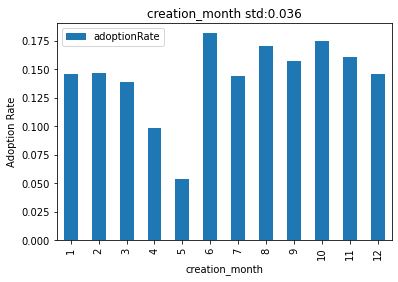

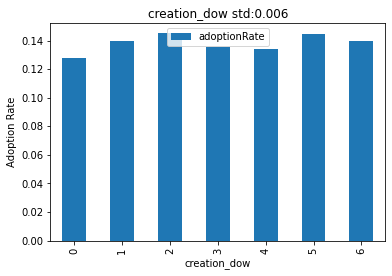

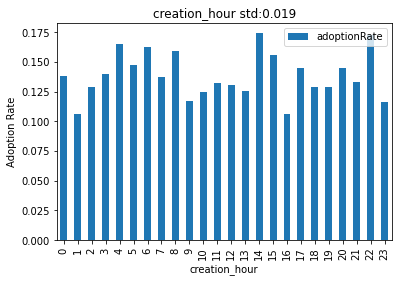

In [19]:
for col in ['creation_month','creation_dow','creation_hour']:
    by_col = users.groupby(col)['adopted'].agg(['count','sum'])
    by_col['adoptionRate'] = by_col['sum'] / by_col['count']
    std_dev = by_col['adoptionRate'].std()
    
    
    by_col.plot(kind='bar',y='adoptionRate')
    plt.ylabel('Adoption Rate')
    plt.xlabel(col)
    plt.title(col+f' std:{std_dev:.3f}')
    plt.show()

The adoption rate does seem to vary by creation month, especially April and May which have low adoption rates. 

The adoption rate varies little by day of the week, but Monday's are lower than the rest.  

The adoption rate for hour of creation varies a bit more than day of the week, but not as much as by month. There do appear to be some trends present for the hour of creation.

`creation_month` and `creation_hour` look useful for prediction.  I'll do a chi2 test to see if the effect is significant.



In [20]:
from scipy.stats import chi2_contingency
for col in ['creation_month','creation_dow','creation_hour']:
    chi2, pval, dof, exp = chi2_contingency( pd.crosstab(users[col], users.adopted) )
    print(f'{col} chi2: {chi2:.3f}, pval: {pval:.3f}')
    

creation_month chi2: 143.569, pval: 0.000
creation_dow chi2: 3.169, pval: 0.787
creation_hour chi2: 34.619, pval: 0.057


Since the pvalue for month is ~0 there is evidence the effect of `creation_month` is statistically significant. Because the p-value for hour is so close to 5% I will say this is also significant and include it in any modelling efforts.  Day of the week does is insignificant

### name

In [21]:
users.name.nunique()

11349

There are some duplicates names.  It looks like some people have multiple accounts.

In [22]:
### Boolean column for if a user has multiple accounts
users['multipleAccounts'] = 0
users.loc[users.name.duplicated(keep=False),'multipleAccounts'] = 1

### column for number of multiple accounts
users = users.merge(pd.DataFrame(users.groupby('name')['name'].count()).rename(columns={'name':'numberAccounts'}),\
            how='left',left_on='name',right_on='name')


In [23]:
users[['multipleAccounts','numberAccounts']]

,multipleAccounts,numberAccounts
0,0,1
1,0,1
2,0,1
3,1,2
4,0,1
...,...,...
11995,0,1
11996,0,1
11997,0,1
11998,0,1


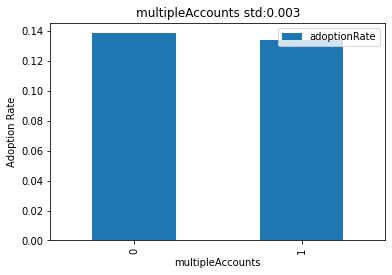

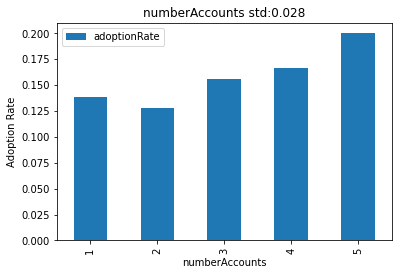

In [24]:
for col in ['multipleAccounts','numberAccounts']:
    by_col = users.groupby(col)['adopted'].agg(['count','sum'])
    by_col['adoptionRate'] = by_col['sum'] / by_col['count']
    std_dev = by_col['adoptionRate'].std()
    
    
    by_col.plot(kind='bar',y='adoptionRate')
    plt.ylabel('Adoption Rate')
    plt.xlabel(col)
    plt.title(col+f' std:{std_dev:.3f}')
    plt.show()

There is very little difference in the adoption rate among whether the user has multiple accounts or not.


In [25]:
for col in ['multipleAccounts','numberAccounts']:
    chi2, pval, dof, exp = chi2_contingency( pd.crosstab(users[col], users.adopted) )
    print(f'{col} chi2: {chi2:.3f}, pval: {pval:.3f}')   
    

multipleAccounts chi2: 0.161, pval: 0.688
numberAccounts chi2: 1.888, pval: 0.756


There is no statstical evidence these calculated columns are associated with whether the user is adopted or not.

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
 11  creation_month              12000 non-null  int64     

### email

In [27]:
users.email.value_counts()

TomSchiffer@gmail.com            2
LaerkeMBertelsen@gmail.com       2
MagnusSWinther@jourrapide.com    2
JacobTye@gmail.com               2
AlfieLane@yahoo.com              2
                                ..
PhoebeKenyon@cuvox.de            1
DiegoBarbosaRocha@yahoo.com      1
LeoMacleod@gustr.com             1
TomWeber@cuvox.de                1
KaiMirams@yahoo.com              1
Name: email, Length: 11980, dtype: int64

There are duplicate emails. Maybe the were users who cancelled and then rejoined.

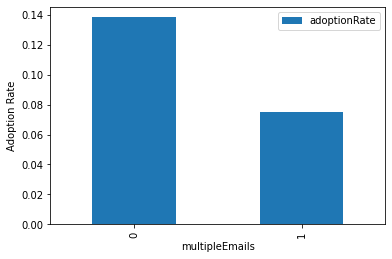

In [28]:
users['multipleEmails'] = 0
users.loc[users.email.duplicated(keep=False),'multipleEmails'] = 1

test = users.groupby('multipleEmails')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.show()

In [29]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.multipleEmails,users.adopted))
print(f'multipleEmails chi2: {chi2:.3f}, pval: {pval:.3f}')

multipleEmails chi2: 0.860, pval: 0.354


If a user has multiple email accounts there seems to be a negative correlation to the adoption rate, but it is not statistically significant. 

### creation_source

In [30]:
users.creation_source.value_counts()/users.shape[0]

ORG_INVITE            0.354500
GUEST_INVITE          0.180250
PERSONAL_PROJECTS     0.175917
SIGNUP                0.173917
SIGNUP_GOOGLE_AUTH    0.115417
Name: creation_source, dtype: float64

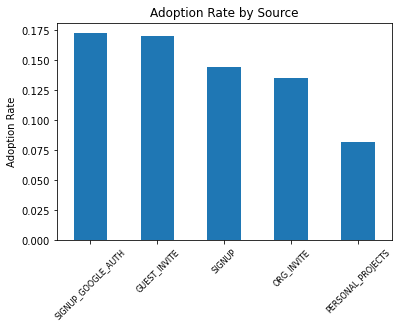

In [31]:
test = users.groupby('creation_source')['adopted'].agg(['count','sum'])
test['adoptionRate'] = test['sum'] / test['count']
test.sort_values('adoptionRate',ascending=False).plot(kind='bar',y='adoptionRate')

plt.title('Adoption Rate by Source')
plt.ylabel('Adoption Rate')
plt.xlabel('')
plt.xticks(rotation=45,fontsize=8)

plt.legend().remove()
plt.show()

In [32]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.creation_source,users.adopted))
print(f'creation_source chi2: {chi2:.3f}, pval: {pval:.3f}')

creation_source chi2: 91.048, pval: 0.000


### last_session_creation_time

In [33]:
users.last_session_creation_time.isna().sum()/users.shape[0]

0.26475

1/4 of the values are null for this column. I will assume this means they never logged in.

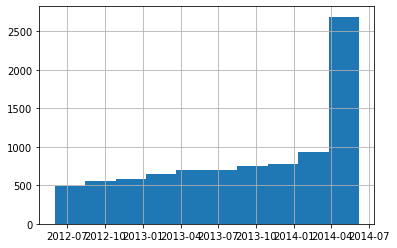

In [34]:
users.last_session_creation_time.hist()
plt.show()

In [35]:
### Assuming the records were pulled on the maximum date in this column

max_date = max(users.last_session_creation_time)
max_date
users['days_since_last_session'] = (max_date - users.last_session_creation_time).dt.days

### I will replace the nulls in this column with the day difference 
### between max_date and when the created their account

users['days_since_last_session'] = users['days_since_last_session'].fillna(\
              (max_date - users.creation_time).dt.days)

### Finally I will create a column that is the number of days
### between account creation and their last session
users['days_last-creation'] = ( users.last_session_creation_time - users.creation_time).dt.days
users['days_last-creation'] = users['days_last-creation'].fillna(0)


users.groupby('adopted')['days_since_last_session','days_last-creation'].describe().T

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


adopted                                 0.0          1.0
days_since_last_session count  10344.000000  1656.000000
                        mean     313.409223    78.740338
                        std      218.611174   155.313460
                        min        0.000000     1.000000
                        25%      113.000000     3.000000
                        50%      294.000000     9.000000
                        75%      496.000000    27.000000
                        max      736.000000   703.000000
days_last-creation      count  10344.000000  1656.000000
                        mean       3.685615   292.507850
                        std       12.732705   206.845348
                        min        0.000000     4.000000
                        25%        0.000000   111.000000
                        50%        0.000000   243.500000
                        75%        1.000000   463.000000
                        max      189.000000   729.000000

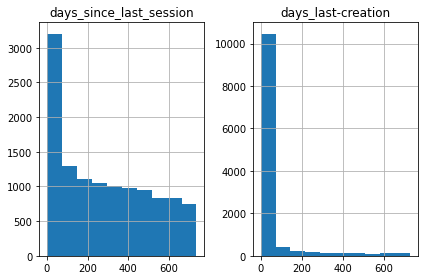

In [36]:
fig,ax = plt.subplots(1,2,tight_layout=True)
users['days_since_last_session'].hist(ax=ax[0])
users['days_last-creation'].hist(ax=ax[1])
ax[0].set_title('days_since_last_session')
ax[1].set_title('days_last-creation')
plt.show()


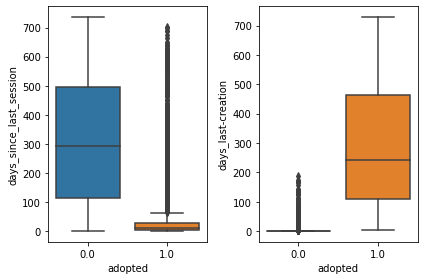

In [37]:
fig,ax = plt.subplots(1,2,tight_layout=True)
sns.boxplot(data=users, x='adopted', y='days_since_last_session',ax=ax[0])
sns.boxplot(data=users, x='adopted', y='days_last-creation',ax=ax[1])

plt.show()

It looks like there is quite a big difference among adopted users and those who are not for these calculated columns.

### opted_in_to_mailing_list

In [38]:
users.opted_in_to_mailing_list.value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

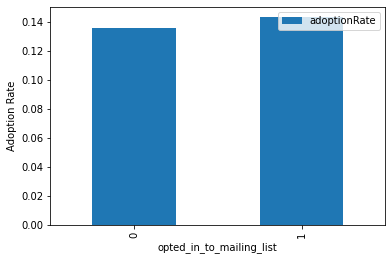

In [39]:
test = users.groupby('opted_in_to_mailing_list')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.show()

There is very little difference in the adoption rate among users who opted in to the mailing list and those that didn't.

In [40]:
### chi2 test
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.opted_in_to_mailing_list,users.adopted))
print(f'Opted_in_to_mailing_list chi2: {chi2:.3f}, pval: {pval:.3f}')

Opted_in_to_mailing_list chi2: 0.879, pval: 0.348


In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
 11  creation_month              12000 non-null  int64     

### enabled_for_marketing_drip

In [42]:
users.enabled_for_marketing_drip.value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

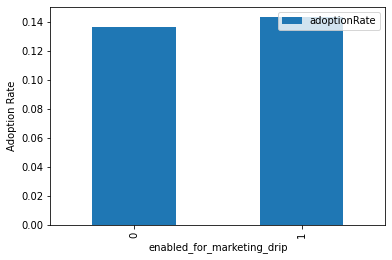

In [43]:
test = users.groupby('enabled_for_marketing_drip')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.show()

Again there is very little difference in the adoption rate among these 2 categories. 

In [44]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.enabled_for_marketing_drip,users.adopted))
print(f'enabled_for_marketing_drip chi2: {chi2:.3f}, pval: {pval:.3f}')

enabled_for_marketing_drip chi2: 0.467, pval: 0.494


And there is no evidence that this observed small difference in adoption rate is statistically significant.

### org_id

In [45]:
users.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
315      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

There are 417 unique organizations and the largest has 319 users.

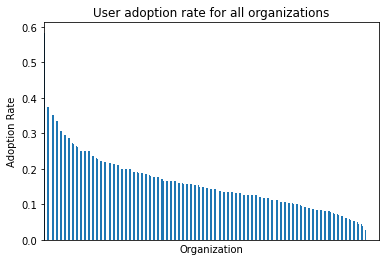

In [46]:
test = users.groupby('org_id')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.sort_values('adoptionRate',ascending=False).plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.xlabel('Organization')
plt.tick_params(axis='x',bottom=False,labelbottom=False)
plt.legend().remove()
plt.title('User adoption rate for all organizations')
plt.show()

There is a wide range of adoption rates among the 417 unique organizations.  

In [47]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.org_id,users.adopted))
print(f'org_id chi2: {chi2:.3f}, pval: {pval:.3f}')

org_id chi2: 541.536, pval: 0.000


There is a strong association between `org_id` and whether the users is adopted. To utilize this feature in modelling I need to encode these somehow. 417 is a lot of categories to encode and one-hot encoding would create a sparse data set.  Applying binary encoding or hashing would greatly reduce the number, but I would sacrifice interpretability.  

This project is more about determining factors that can predict adoption than about creating an accurate model.  I need to keep that in mind.  Thus, I will try one hot encoding first. These will be implemented in the next section.

In [48]:
### additoinal columns needed for binary encoding
print(round(np.log2(417)))

9


In [49]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
 11  creation_month              12000 non-null  int64     

### invited_by_user_id


This column is about half null.  I will create a binary column to represent if a user was invited or not

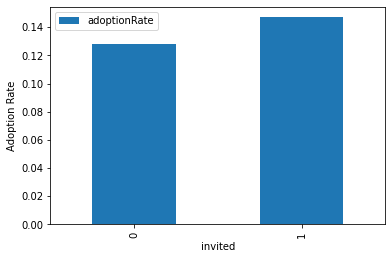

In [50]:
users['invited'] = 1 - users.invited_by_user_id.isna()

test = users.groupby('invited')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.show()

It looks like the users that were invited were a little more likely to become adopted users.

In [51]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(users.invited,users.adopted))
print(f'invited chi2: {chi2:.3f}, pval: {pval:.3f}')

invited chi2: 9.134, pval: 0.003


There is statistical evidence of an association between being invited and adoption. Does the adoption rate vary depending on the inviter?

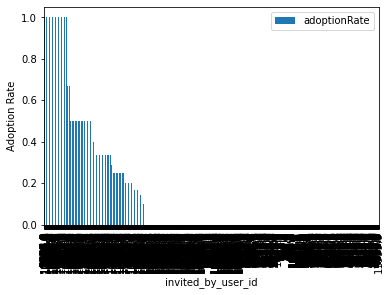

In [52]:
test = users.groupby('invited_by_user_id')['adopted'].agg(['sum','count'])
test['adoptionRate'] = test['sum'] / test['count']
test.sort_values('adoptionRate',ascending=False).plot(kind='bar',y='adoptionRate')
plt.ylabel('Adoption Rate')
plt.show()

In [53]:
test.sort_values(['count','adoptionRate'],ascending=False)

,sum,count,adoptionRate
invited_by_user_id,,,
10741.0,1.0,13,0.076923
2527.0,2.0,12,0.166667
2308.0,1.0,11,0.090909
11770.0,1.0,11,0.090909
1525.0,0.0,11,0.000000
...,...,...,...
11974.0,0.0,1,0.000000
11978.0,0.0,1,0.000000
11981.0,0.0,1,0.000000


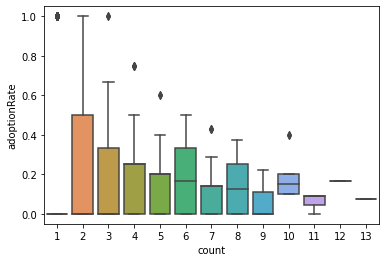

In [54]:
sns.boxplot(x=test['count'], y=test['adoptionRate'])
plt.show()

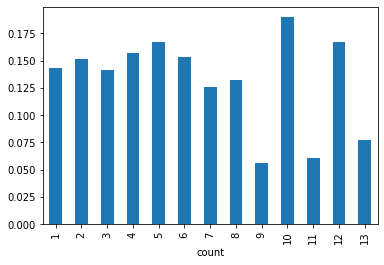

In [55]:
test.groupby('count')['adoptionRate'].mean().plot(kind='bar')
plt.show()

In [56]:
test[test['count']>8].shape

(29, 3)

The adoption rate does not vary much below 8 invites, and there are only a small number of examples beyond that.

### session data
Here I will create some new columns using the sessions data to add to the 
1. Number of sessions in first 7 days
1. Number of sessions in first 14 days
1. Number of sessions in first 30 days


In [57]:
engagement = engagement.merge(users[['user_id','creation_time']],how='left',left_on='user_id',right_on='user_id',validate='m:1')
engagement['days_since_creation'] = (engagement.time_stamp - engagement.creation_time).dt.days
engagement.head(10)

,time_stamp,user_id,visited,creation_time,days_since_creation
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,0
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,14
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,24
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,40
5,2013-12-31 03:45:04,2,1,2013-11-15 03:45:04,46
6,2014-01-08 03:45:04,2,1,2013-11-15 03:45:04,54
7,2014-02-03 03:45:04,2,1,2013-11-15 03:45:04,80
8,2014-02-08 03:45:04,2,1,2013-11-15 03:45:04,85
9,2014-02-09 03:45:04,2,1,2013-11-15 03:45:04,86


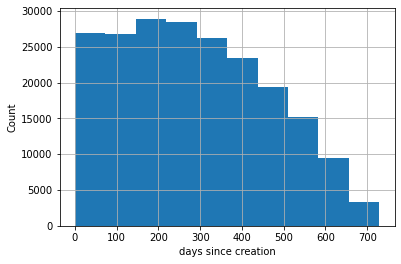

In [58]:
engagement.days_since_creation.hist()
plt.ylabel('Count')
plt.xlabel('days since creation')
plt.show()

In [59]:
for d in [7,14,30]:
    dum = engagement[engagement.days_since_creation<=d].groupby('user_id')['visited'].count()
    dum.name = 'sessions_first_'+str(d)+'days'
    users = users.merge(dum,how='left',left_on='user_id',right_index=True,validate='1:1')
    users['sessions_first_'+str(d)+'days'] = users['sessions_first_'+str(d)+'days'].fillna(0)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
 11  creation_month              12000 non-null  int64     

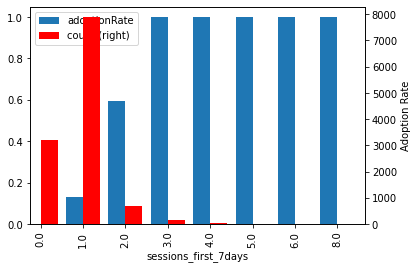

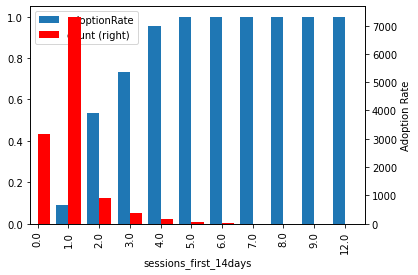

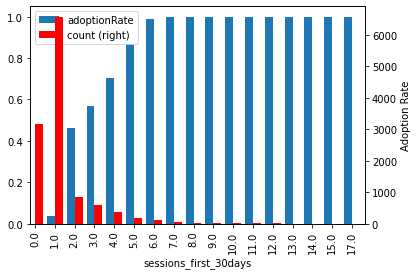

In [60]:
for d in [7,14,30]:
    
    test = users.groupby('sessions_first_'+str(d)+'days')['adopted'].agg(['sum','count'])
    test['adoptionRate'] = test['sum'] / test['count']
    width=.4
    fig,ax = plt.subplots(1,1)
    test.plot(kind='bar',y='adoptionRate',ax=ax,position=1,\
              width=width)
    test.plot(kind='bar',y='count',ax=ax,secondary_y=True,\
              position=0,color='red',width=width)
    plt.ylabel('Adoption Rate')
    plt.show()
    

Very interesting.  These plots indicate that a users sessions in the first 7, 14, and 30 days is highly correlative to whether the user is adopted.  I will proceed with the `sessions_first_14days` for modelling.

Done with analysis.  Now I will create a quick classifier model and to see what is feature is most important for prediciting association.  

### Feature Engineering
I created some new features above, but here I will encode the categorical columns. Then I will calculate information value and collinearity before moving to modelling.  

In [61]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
 11  creation_month              12000 non-null  int64     

Firstly one hot encoding of the different categories of `creation_source` (5 categories).

In [62]:
users = pd.get_dummies(users,columns=['creation_source'],prefix='source')

Now one hot encoding of the `org_id` (417 unique orgs).

hashing `org_id` into 8 columns

In [63]:
### for hashing 'org_id', fewer columns but some collisions
import category_encoders as ce
hashing = ce.HashingEncoder(cols=['org_id'],n_components=8)
X = users
y = users[['adopted']]
hashing.fit(X,y)
users = hashing.transform(X)
newcols = [j for j in users.columns if j.startswith('col_')]
mapper = {k:'org_id_'+k[-1] for k in newcols}
users = users.rename(columns=mapper)

C:\Users\blain\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [64]:
users.shape

(12000, 34)

In [65]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   org_id_0                    12000 non-null  int64         
 1   org_id_1                    12000 non-null  int64         
 2   org_id_2                    12000 non-null  int64         
 3   org_id_3                    12000 non-null  int64         
 4   org_id_4                    12000 non-null  int64         
 5   org_id_5                    12000 non-null  int64         
 6   org_id_6                    12000 non-null  int64         
 7   org_id_7                    12000 non-null  int64         
 8   user_id                     12000 non-null  int64         
 9   creation_time               12000 non-null  datetime64[ns]
 10  name                        12000 non-null  object        
 11  email                       12000 non-null  object    

Function for calculating information value for each feature.

In [66]:
### Function to calculate the Information Value (IV) of each feature
### 


max_bin = 20
force_bin = 3
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import re


# define a binning function
### this function is for binning and calculating the Weight of Evidence 
### for the target and the Information Value for the feature
### and the In
def mono_bin(Y, X, n = max_bin):    
    ### create new dataframe of series feature and series y
    df1 = pd.DataFrame({"X": X, "Y": Y})
    
    ### check to see if any nulls in feature and seperate nulls out
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    
    
    ### while loop until Spearman correlation coefficient is between [-1,1]
    ### Finding minumum bin size that results in 'abs(r)' of >1???
    
    r = 0
    while np.abs(r) < 1:
        ### Try creation of new dataframe with max or less bin size 'n'
        ### create dataframe with feature, target and binned feature 
        ### create 'd2' group by object on 'Bucket'
        ### calculate Spearman correlation 'r' and p-value from mean of feature and target
        ### If exception reduce bin number by one and try again
        ### Effectively finding the max bin number that can be used 
        ### for calculating WOE
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y,\
                               "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
                             
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    ### If length of d2 is 1 (ie 1 bucket for all of feature) do this
    if len(d2) == 1:
        #print("I am second step ",r, n)
        
        ### force 'n' to 3 and calculate quantiles of feature from (0,0.5,1) 
        ### to be used as bins, if not 3 unique because of heavily skewed data
        ### manually create bin
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
            
        ### Create new dataframe bucketed by manual bins
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    ### Create new dataframe from aggregating the binned dataframe
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    ### add more features to d3 describing the 'events' of the target
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    import traceback
    
    
    ### Extract raw traceback from error in one of the two sub functions
    ### assign traceback elemnts to variables
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    
    
    
    ###
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    
    ### get column names from df1
    x = df1.dtypes.index
    
    count = -1
    ### Loop through columns
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            ### test if numeric and not a one-hot encoding
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                ###  pass target and feature to 'mono_bin'
                conv = mono_bin(target, df1[i])
                
                ### assign feature name to 'conv'
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                ###  pass target and feature to 'char_bin'
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1

            ### First time run through the loop where count==0,
            ### create new df from current
            if count == 0:
                iv_df = conv
            ### on subsequent loops append rows to bottom of 'iv_df'
            ### of next feature and scoring calcs
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    ### aggregate 'iv_df' taking the maximum ?correlation? score 
    ### for each feature and creating a new summary df with columns 
    ### 'VAR_NAME' & 'IV'
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    ### return detailed df with all computed features
    ### and summary of only max values and feature names
    return(iv_df,iv)

In [67]:
X = users.drop(['user_id','creation_time','name','email','last_session_creation_time','invited_by_user_id','days_since_last_session','days_last-creation','adopted'],axis=1)
y = users['adopted']
iv_df, iv = data_vars(X, y)

org_id_0
org_id_1
org_id_2
org_id_3
org_id_4
org_id_5
org_id_6
org_id_7
opted_in_to_mailing_list
enabled_for_marketing_drip
creation_month
0   -0.154135
1    0.167970
dtype: float64
creation_dow
0   -0.006978
1    0.009259
dtype: float64
creation_hour
0   -0.005361
1    0.006311
dtype: float64
multipleAccounts
numberAccounts
0    0.003958
1   -0.035544
dtype: float64
multipleEmails
invited
sessions_first_7days
0   -0.438704
1    2.622081
dtype: float64
sessions_first_14days
0   -0.847047
1    2.462011
dtype: float64
sessions_first_30days
0   -1.809593
1    2.343064
dtype: float64
source_GUEST_INVITE
source_ORG_INVITE
source_PERSONAL_PROJECTS
source_SIGNUP
source_SIGNUP_GOOGLE_AUTH


In [68]:
iv = iv.sort_values('IV',ascending=False)
iv.head(10)

,VAR_NAME,IV
18,sessions_first_30days,3.189425
17,sessions_first_14days,1.794947
19,sessions_first_7days,1.057549
22,source_PERSONAL_PROJECTS,0.057537
2,creation_month,0.025834
20,source_GUEST_INVITE,0.015421
24,source_SIGNUP_GOOGLE_AUTH,0.010157
4,invited,0.006547
11,org_id_2,0.005184
12,org_id_3,0.004668


In [69]:
features = list(iv.loc[iv.IV>0.01,'VAR_NAME'])
X2 = X[features]

Now dropping columns based on multicollinearity

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        
        ### Create data frame with features column and 
        ### variance inflation factor column
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
            #if count==45:
                #print('early stop for plotting intermediate step')
                #return df, vif.sort_values('VIFactor')  
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  


In [71]:
final_df, final_vif = iterate_vif(X2._get_numeric_data())

Iteration # 1
Removing sessions_first_14days with VIF of 23.376329
Iteration # 2
Removing sessions_first_7days with VIF of 5.647840
Iteration # 3
Complete


In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sessions_first_30days      12000 non-null  float64
 1   source_PERSONAL_PROJECTS   12000 non-null  uint8  
 2   creation_month             12000 non-null  int64  
 3   source_GUEST_INVITE        12000 non-null  uint8  
 4   source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
dtypes: float64(1), int64(1), uint8(3)
memory usage: 222.8 KB


Ready for modelling

## Modelling
- I will only use features that are available on sign up or shortly there after for predicting future user adoption. 
- Apply Random Forest classifier for prediction adoption
- Evaluate feature importance

In [73]:
rand_seed=33

In [74]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sessions_first_30days      12000 non-null  float64
 1   source_PERSONAL_PROJECTS   12000 non-null  uint8  
 2   creation_month             12000 non-null  int64  
 3   source_GUEST_INVITE        12000 non-null  uint8  
 4   source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
dtypes: float64(1), int64(1), uint8(3)
memory usage: 222.8 KB


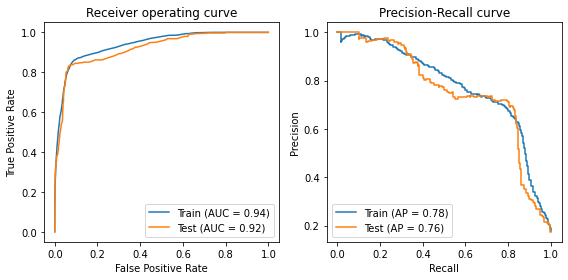

In [75]:
#X_labels = ['creation_month','creation_hour','source_GUEST_INVITE',\
#            'source_ORG_INVITE','source_PERSONAL_PROJECTS','source_SIGNUP',\
#            'source_SIGNUP_GOOGLE_AUTH','org_id_adoption_rate','invited']#,\
#            #'days_last-creation']#'days_since_last_session']#,'days_last-creation']

X_labels = list(final_df.columns)
y_label='adopted'

X = final_df.to_numpy()
y = users[y_label].to_numpy()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve,plot_precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,\
                                                    random_state=rand_seed)

params = {'n_estimators':[30,50,80,100], 'max_depth':[3,5,7]}
rfgs = GridSearchCV(RandomForestClassifier(),param_grid=params,cv=5,\
                    scoring='roc_auc')

rfgs.fit(X_train,y_train)

fig,ax = plt.subplots(1,2,figsize=(8,4),tight_layout=True)
plot_roc_curve(rfgs.best_estimator_,X_train,y_train,ax=ax[0],name='Train')
plot_roc_curve(rfgs.best_estimator_,X_test,y_test,ax=ax[0],name='Test')
ax[0].set_title('Receiver operating curve')

plot_precision_recall_curve(rfgs.best_estimator_,X_train,y_train,\
                            ax=ax[1],name='Train')
plot_precision_recall_curve(rfgs.best_estimator_,X_test,y_test,\
                            ax=ax[1],name='Test')
ax[1].set_title('Precision-Recall curve')
plt.show()



That looks great.  A test AUC of 0.92 is a good result that demonstrates the predictive power of the features and curves show it is not overfit to the training data.  Checking feature importance

In [76]:
pd.DataFrame(zip(X_labels,rfgs.best_estimator_.feature_importances_),\
             columns=['feature','import']).sort_values('import',ascending=False)

,feature,import
0,sessions_first_30days,0.946146
2,creation_month,0.043497
1,source_PERSONAL_PROJECTS,0.006538
4,source_SIGNUP_GOOGLE_AUTH,0.001948
3,source_GUEST_INVITE,0.001872


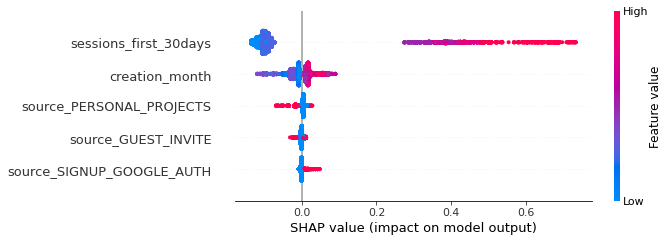

In [77]:
import shap

shap_values = shap.TreeExplainer(rfgs.best_estimator_).shap_values(X_train)

shap.summary_plot(shap_values[1], X_train,\
                  feature_names=X_labels,\
                  class_names=['lost','adopted'])

The most important features for prediciting future user adoption are `sessions_first_30days`, the number of the users sessions in the first 30 days since joining, and `creation_month`, the the month they joined Relax.

Other features useful for prediction are the sources of the account 'Personal Projects', 'Guest Invite', 'Signup Google'.